In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import cv2
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  imutils import paths
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from PIL import Image  # Image handling
from glob import glob
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight



In [2]:
from imutils import paths
import random
import shutil
import os

# Step 1: Create a new folder "Dataset" and copy the extracted dataset there
EXTRACTED_DATASET = "/kaggle/input/breast-histopathology-images"  # Original dataset location
NEW_DATASET_PATH = "/kaggle/working/Dataset"  # New folder

# Ensure the new dataset directory exists
os.makedirs(NEW_DATASET_PATH, exist_ok=True)

# Copy all files from extracted dataset to the new "Dataset" folder
for root, _, files in os.walk(EXTRACTED_DATASET):
    for file in files:
        src_path = os.path.join(root, file)
        dst_path = os.path.join(NEW_DATASET_PATH, file)

        # Skip copying if the file already exists
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)  # Copy instead of move

print(" Dataset successfully copied to 'Dataset' folder.")

# Step 2: Define dataset structure
INPUT_DATASET = NEW_DATASET_PATH  # Use the new dataset location
BASE_PATH = "/kaggle/working/datasets/idc"

# Define training, validation, and testing paths
TRAIN_PATH = os.path.join(BASE_PATH, "training")
VAL_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "testing")

# Define dataset splits
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

# Step 3: Get all image paths and shuffle them
image_paths = list(paths.list_images(INPUT_DATASET))
random.seed(7)
random.shuffle(image_paths)

# Split dataset into training, validation, and testing sets
index = int(len(image_paths) * TRAIN_SPLIT)
train_paths = image_paths[:index]
test_paths = image_paths[index:]

index = int(len(train_paths) * VAL_SPLIT)
val_paths = train_paths[:index]
train_paths = train_paths[index:]

# Define dataset structure
datasets = [
    ("training", train_paths, TRAIN_PATH),
    ("validation", val_paths, VAL_PATH),
    ("testing", test_paths, TEST_PATH)
]

# Step 4: Organize images into respective folders
for set_type, image_paths, base_path in datasets:
    print(f" Organizing {set_type} set...")
    os.makedirs(base_path, exist_ok=True)

    for path in image_paths:
        file = path.split(os.path.sep)[-1]
        label = file[-5:-4]  # Extract label from filename

        label_path = os.path.join(base_path, label)
        os.makedirs(label_path, exist_ok=True)

        new_path = os.path.join(label_path, file)

        # Skip copying if the file already exists
        if not os.path.exists(new_path):
            shutil.copy2(path, new_path)  # Copy instead of move

print(" Dataset successfully split and stored in:")
print(f"Training Path: {TRAIN_PATH}")
print(f"Validation Path: {VAL_PATH}")
print(f"Testing Path: {TEST_PATH}")

# Step 5: Verify dataset structure
for folder in ["training", "validation", "testing"]:
    folder_path = os.path.join(BASE_PATH, folder)
    print(f"\n Checking {folder} set:")

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            print(f"   Label {label}: {len(os.listdir(label_path))} images")


 Dataset successfully copied to 'Dataset' folder.
 Organizing training set...
 Organizing validation set...
 Organizing testing set...
 Dataset successfully split and stored in:
Training Path: /kaggle/working/datasets/idc/training
Validation Path: /kaggle/working/datasets/idc/validation
Testing Path: /kaggle/working/datasets/idc/testing

 Checking training set:
   Label 0: 143176 images
   Label 1: 56642 images

 Checking validation set:
   Label 0: 15820 images
   Label 1: 6381 images

 Checking testing set:
   Label 0: 39742 images
   Label 1: 15763 images


 Total positive images selected: 15
 Total negative images selected: 15


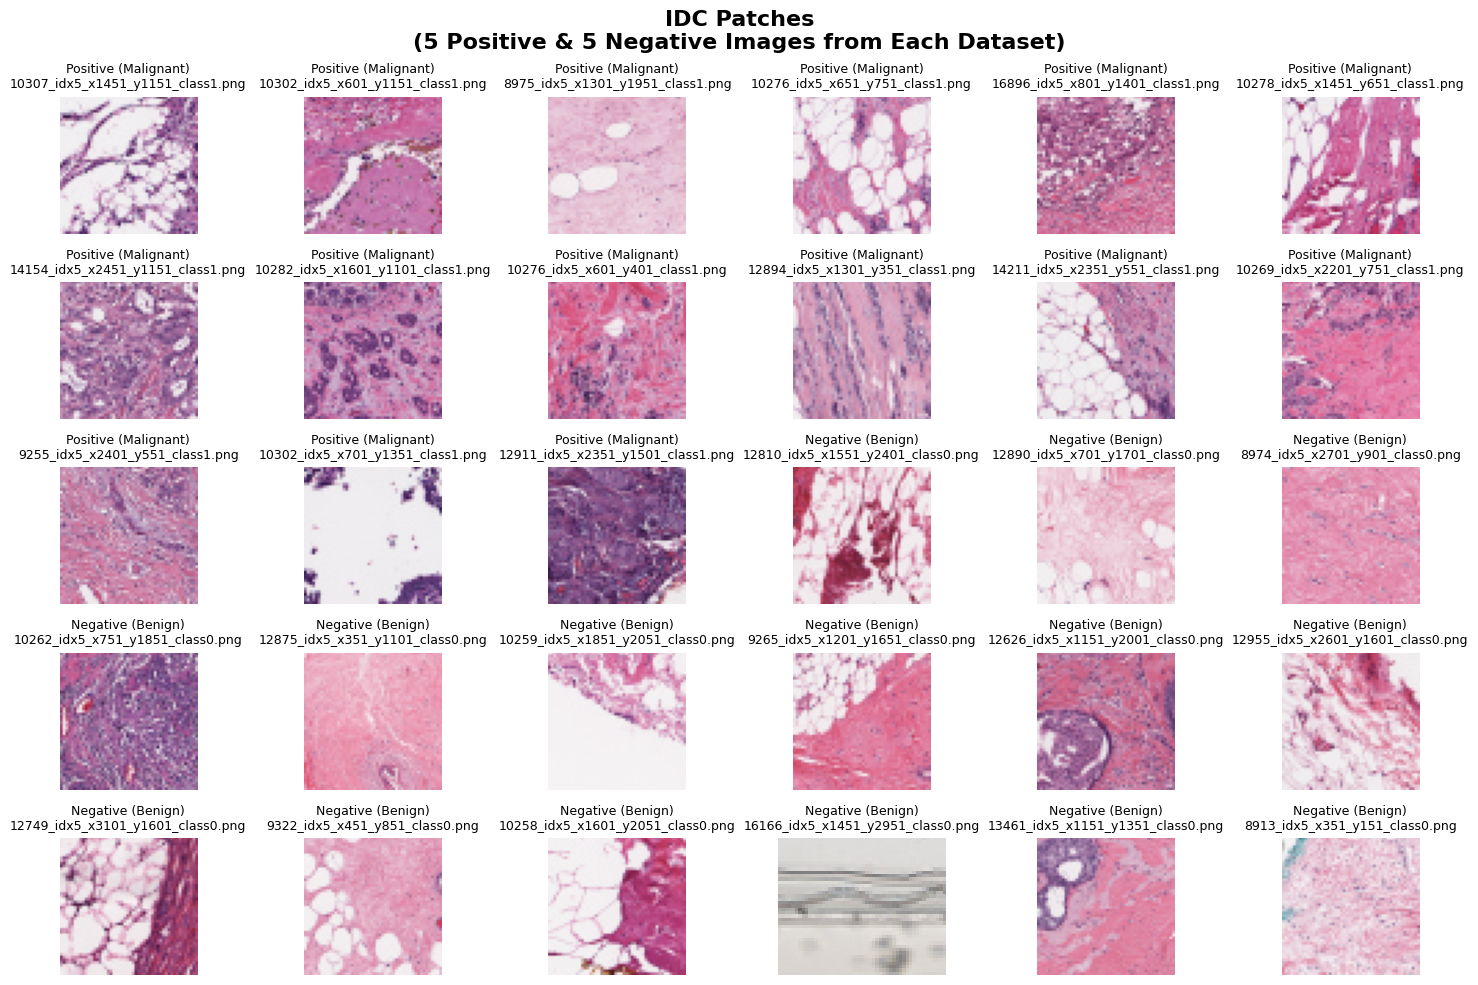

In [3]:
# Define dataset directories (Kaggle paths)
dataset_dirs = [
    "/kaggle/working/datasets/idc/testing",
    "/kaggle/working/datasets/idc/training",
    "/kaggle/working/datasets/idc/validation"
]

# Initialize lists to store image paths
positive_images = []
negative_images = []

# Collect images from each dataset directory
for directory in dataset_dirs:
    if os.path.exists(directory):
        pos_temp = []
        neg_temp = []

        for root, _, files in os.walk(directory):  # Walk through subdirectories
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    if '1' in os.path.basename(root):  # Class 1 = Positive (Malignant)
                        pos_temp.append(os.path.join(root, file))
                    elif '0' in os.path.basename(root):  # Class 0 = Negative (Benign)
                        neg_temp.append(os.path.join(root, file))

        # Shuffle and select 5 images from each category per dataset
        random.shuffle(pos_temp)
        random.shuffle(neg_temp)
        positive_images.extend(pos_temp[:5])
        negative_images.extend(neg_temp[:5])

# Debugging: Check if images were found
print(" Total positive images selected:", len(positive_images))
print(" Total negative images selected:", len(negative_images))

# Ensure we have enough images to display
if len(positive_images) < 15 or len(negative_images) < 15:
    print(" Error: Not enough positive or negative images found in all datasets.")
else:
    # Combine selected images
    selected_images = positive_images[:15] + negative_images[:15]

    # Set grid size (5 rows × 6 columns)
    rows, cols = 5, 6
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Plot images in a grid
    for i, ax in enumerate(axes.flat):
        if i < len(selected_images):
            img_path = selected_images[i]
            img = cv2.imread(img_path)  # Read image
            if img is None:
                print(f"⚠ Error loading image: {img_path}")
                ax.axis('off')
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            category = "Positive (Malignant)" if i < 15 else "Negative (Benign)"
            ax.imshow(img)
            ax.set_title(f"{category}\n{os.path.basename(img_path)}", fontsize=9)  # Show filename & category
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide unused subplots if fewer than 30 images

    # Adjust layout
    plt.suptitle("IDC Patches\n(5 Positive & 5 Negative Images from Each Dataset)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [4]:
import tensorflow as tf
from keras import backend as K

class CancerNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = tf.keras.models.Sequential()
        shape = (height, width, depth)
        channelDim = -1  # Default for "channels_last"

        if K.image_data_format() == "channels_first":
            shape = (depth, height, width)
            channelDim = 1  # Adjust for "channels_first"

        # 1st Convolutional Block
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=shape))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
        model.add(tf.keras.layers.Dropout(0.25))

        # 2nd Convolutional Block
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
        model.add(tf.keras.layers.Dropout(0.25))

        # 3rd Convolutional Block
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
        model.add(tf.keras.layers.Dropout(0.25))

        # Fully Connected Layers
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=256, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=channelDim))
        model.add(tf.keras.layers.Dropout(0.5))

        # Output Layer
        model.add(tf.keras.layers.Dense(units=classes, activation='softmax'))
        
        return model


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths (update if needed)
TRAIN_PATH = "/kaggle/working/datasets/idc/training"
VAL_PATH = "/kaggle/working/datasets/idc/validation"

# Ensure paths exist
if not os.path.exists(TRAIN_PATH) or not os.path.exists(VAL_PATH):
    print("Error: Dataset folders not found. Check the paths!")
else:
    print("✅ Dataset paths verified.")

# Create ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom transformations
    horizontal_flip=True   # Randomly flip images
)

# Create ImageDataGenerator for validation (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale

# Load training data
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(64,64),   # Resize images
    batch_size=32,
    class_mode='binary'    # Binary classification (IDC present or not)
)

# Load validation data
validation_set = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(64,64),
    batch_size=32,
    class_mode='binary'
)

print(" Data Generators Created Successfully!")


✅ Dataset paths verified.
Found 199818 images belonging to 2 classes.
Found 22201 images belonging to 2 classes.
 Data Generators Created Successfully!


In [6]:
import os
import numpy as np
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

# Constants
NUM_EPOCHS = 30
INIT_LR = 1e-2
BS = 32

# Dataset Paths (Update if needed)
BASE_PATH = "/kaggle/working/datasets/idc"
TRAIN_PATH = os.path.join(BASE_PATH, "training")
VAL_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "testing")

# Check if dataset exists
if not os.path.exists(TRAIN_PATH) or not os.path.exists(VAL_PATH) or not os.path.exists(TEST_PATH):
    raise ValueError(" Dataset paths not found. Check dataset directory!")

# Count total images
trainPaths = list(paths.list_images(TRAIN_PATH))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

print(f" Total Training Images: {totalTrain}")
print(f" Total Validation Images: {totalVal}")
print(f" Total Testing Images: {totalTest}")

# Data Augmentation
trainAug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valAug = ImageDataGenerator(rescale=1./255)

# Data Generators
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=True,
    batch_size=BS
)

valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS
)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS
)

#  Fix Class Weights Calculation
class_indices = trainGen.class_indices  # Get class labels
num_classes = len(class_indices)

# Get class counts
class_totals = np.array([len(os.listdir(os.path.join(TRAIN_PATH, str(i)))) for i in range(num_classes)])

# Avoid division errors
class_weight = np.clip(class_totals.max() / (class_totals + 1e-6), 0, 10)  

print(" Class Weights:", class_weight)


 Total Training Images: 199818
 Total Validation Images: 22201
 Total Testing Images: 55505
Found 199818 images belonging to 2 classes.
Found 22201 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.
 Class Weights: [1.        2.5277356]


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Build and compile the model
model = CancerNet.build(width=48, height=48, depth=3, classes=2)

model.compile(
    loss='categorical_crossentropy',  # Fixed loss function
    optimizer='adam',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train the model with class weights
M = model.fit(
    trainGen,  #  trainGen directly (No need for `x=`)
    validation_data=valGen,
    epochs=30,
    callbacks=[early_stopping],
    class_weight=dict(enumerate(class_weight))  #  Add class weights
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6245/6245 ━━━━━━━━━━━━━━━━━━━━ 339s 52ms/step - accuracy: 0.7784 - loss: 0.7298 - val_accuracy: 0.6131 - val_loss: 0.7300
Epoch 2/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 270s 43ms/step - accuracy: 0.8191 - loss: 0.5961 - val_accuracy: 0.7728 - val_loss: 1.4555
Epoch 3/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 259s 41ms/step - accuracy: 0.8297 - loss: 0.5671 - val_accuracy: 0.7547 - val_loss: 1.8877
Epoch 4/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 251s 40ms/step - accuracy: 0.8341 - loss: 0.5493 - val_accuracy: 0.8382 - val_loss: 0.4356
Epoch 5/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 251s 40ms/step - accuracy: 0.8395 - loss: 0.5373 - val_accuracy: 0.8418 - val_loss: 0.3926
Epoch 6/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 250s 40ms/step - accuracy: 0.8447 - loss: 0.5247 - val_accuracy: 0.8436 - val_loss: 0.3812
Epoch 7/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 256s 41ms/step - accuracy: 0.8458 - loss: 0.5192 - val_accuracy: 0.8666 - val_loss: 0.3229
Epoch 8/30
6245/6245 ━━━━━━━━━━━━━━━━━━━━ 257s 41ms/step - accuracy: 0.8493 - lo

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef

print("Now evaluating the model...")
testGen.reset()

# Predict using the test generator
pred_indices = model.predict(testGen, steps=(totalTest // BS) + 1)
pred_indices = np.argmax(pred_indices, axis=1)  # Get class indices from probabilities

Now evaluating the model...
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step


In [9]:
# Classification Report
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))

# Compute Confusion Matrix
cm = confusion_matrix(testGen.classes, pred_indices)
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) != 0 else 0

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     39742
           1       0.76      0.78      0.77     15763

    accuracy                           0.87     55505
   macro avg       0.84      0.84      0.84     55505
weighted avg       0.87      0.87      0.87     55505



In [10]:
# Compute Additional Metrics
precision_micro = precision_score(testGen.classes, pred_indices, average='micro')
precision_macro = precision_score(testGen.classes, pred_indices, average='macro')
recall_micro = recall_score(testGen.classes, pred_indices, average='micro')
recall_macro = recall_score(testGen.classes, pred_indices, average='macro')
f1_micro = f1_score(testGen.classes, pred_indices, average='micro')
f1_macro = f1_score(testGen.classes, pred_indices, average='macro')
mcc = matthews_corrcoef(testGen.classes, pred_indices)

In [11]:
# Print Metrics
print("\nConfusion Matrix:\n", cm)
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"MCC: {mcc:.4f}")


Confusion Matrix:
 [[35896  3846]
 [ 3404 12359]]

Metrics:
Accuracy: 0.8694
Sensitivity: 0.9032
Specificity: 0.7841
Precision (Micro): 0.8694
Precision (Macro): 0.8380
Recall (Micro): 0.8694
Recall (Macro): 0.8436
F1 Score (Micro): 0.8694
F1 Score (Macro): 0.8407
MCC: 0.6816



Plot saved as 'plot.png'


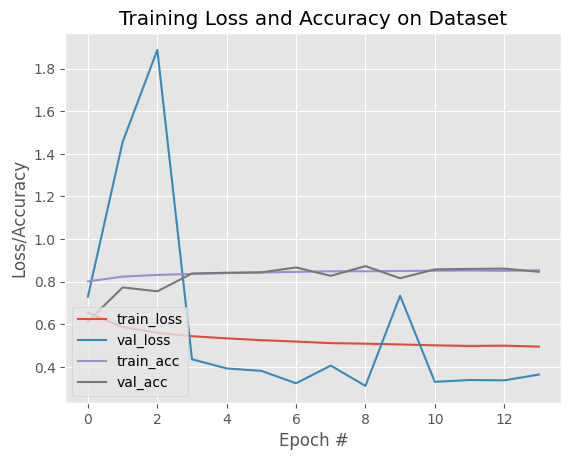

In [12]:
# Plot Loss & Accuracy
plt.style.use("ggplot")
plt.figure()
N = len(M.history["loss"])
plt.plot(np.arange(0, N), M.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

print("\nPlot saved as 'plot.png'")

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step


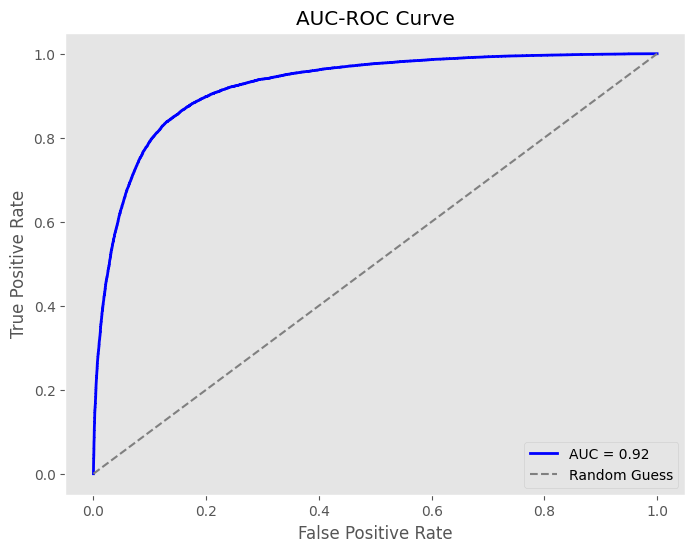

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming testGen.classes contains the true labels
y_true = testGen.classes  

# Get model predictions (probabilities)
y_pred_probs = model.predict(testGen)[:, 1]  # Assuming binary classification

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


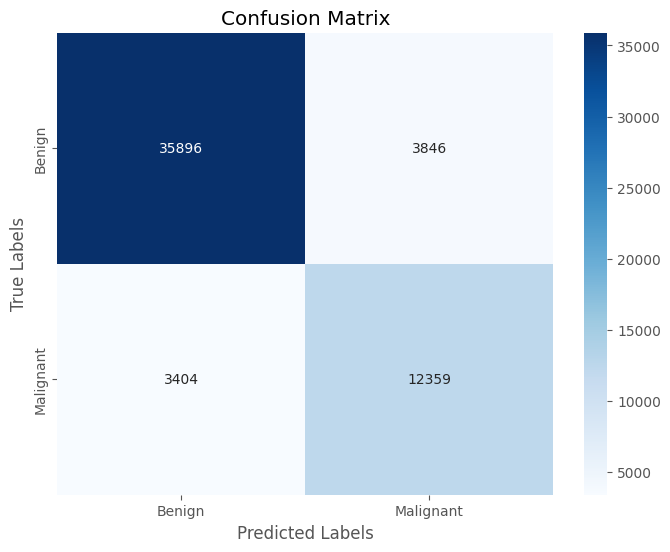

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(testGen.classes, pred_indices)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Save the entire model (architecture + weights + optimizer state)
model.save("cancer_detection_model.h5")

print("Model saved as 'cancer_detection_model.h5'")


Model saved as 'cancer_detection_model.h5'


In [16]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("cancer_detection_model.h5")

# Verify model architecture
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 19, 19, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 3, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 186,692 (729.27 KB)

 Trainable params: 185,474 (724.51 KB)

 Non-trainable params: 1,216 (4.75 KB)

 Optimizer params: 2 (12.00 B)

In [17]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("cancer_detection_model.h5")

# Function to preprocess the image
def preprocess_image(image_path, target_size=(48, 48)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to model's input size
    image = image.astype("float32") / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict the class
def predict_image(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)  # Get prediction probabilities
    class_idx = np.argmax(prediction)  # Get the predicted class index
    class_labels = ["Benign (Non-Cancerous)", "Malignant (Cancerous)"]  # Class labels

    print(f"Predicted Class: {class_labels[class_idx]}")  # Display result
    print(f"Confidence: {prediction[0][class_idx]:.4f}")

# Example usage
image_path = "/kaggle/input/images/b1.png"  # Change this to your image path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
Predicted Class: Benign (Non-Cancerous)
Confidence: 0.6025


In [18]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("cancer_detection_model.h5")

# Function to preprocess the image
def preprocess_image(image_path, target_size=(48, 48)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to model's input size
    image = image.astype("float32") / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict the class
def predict_image(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)  # Get prediction probabilities
    class_idx = np.argmax(prediction)  # Get the predicted class index
    class_labels = ["Benign (Non-Cancerous)", "Malignant (Cancerous)"]  # Class labels

    print(f"Predicted Class: {class_labels[class_idx]}")  # Display result
    print(f"Confidence: {prediction[0][class_idx]:.4f}")

# Example usage
image_path = "/kaggle/input/images/b2.jpeg"    
# Change this to your image path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Predicted Class: Benign (Non-Cancerous)
Confidence: 0.9350


In [19]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("cancer_detection_model.h5")

# Function to preprocess the image
def preprocess_image(image_path, target_size=(48, 48)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to model's input size
    image = image.astype("float32") / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict the class
def predict_image(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)  # Get prediction probabilities
    class_idx = np.argmax(prediction)  # Get the predicted class index
    class_labels = ["Benign (Non-Cancerous)", "Malignant (Cancerous)"]  # Class labels

    print(f"Predicted Class: {class_labels[class_idx]}")  # Display result
    print(f"Confidence: {prediction[0][class_idx]:.4f}")

# Example usage
image_path = "/kaggle/input/images/b3.jpeg"    
# Change this to your image path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Predicted Class: Malignant (Cancerous)
Confidence: 0.7913
